# 库导入

In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model

tf.compat.v1.disable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# 数据导入

In [2]:
index80 = 1

Intrain80 = np.load('data/IncIntrain%s.npy' % index80)
Outtrain80 = np.load('data/IncOuttrain%s.npy' % index80)

InLtrain80 = np.load('data/IncIntrain%s.npy' % index80)
OutLtrain80 = np.load('data/EnOutLtrain%s.npy' % index80)

Intest80 = np.load('data/IncIntest%s.npy' % index80)
Outtest80 = np.load('data/IncOuttest%s.npy' % index80)

InLtest80 = np.load('data/IncIntest%s.npy' % index80)
OutLtest80 = np.load('data/EnOutLtest%s.npy' % index80)

print(Intrain80.shape, OutLtrain80.shape, Outtest80.shape, OutLtest80.shape)

index101 = 2

Intrain101 = np.load('data/IncIntrain%s.npy' % index101)
Outtrain101 = np.load('data/IncOuttrain%s.npy' % index101)

InLtrain101 = np.load('data/IncIntrain%s.npy' % index101)
OutLtrain101 = np.load('data/EnOutLtrain%s.npy' % index101)

Intest101 = np.load('data/IncIntest%s.npy' % index101)
Outtest101 = np.load('data/IncOuttest%s.npy' % index101)

InLtest101 = np.load('data/IncIntest%s.npy' % index101)
OutLtest101 = np.load('data/EnOutLtest%s.npy' % index101)

print(Intrain101.shape, OutLtrain101.shape,
      Outtest101.shape, OutLtest101.shape)


Intrain = np.concatenate((Intrain80,Intrain101),axis=0)
Outtrain = np.concatenate((Outtrain80,Outtrain101),axis=0)

InLtrain = np.concatenate((InLtrain80,InLtrain101),axis=0)
OutLtrain = np.concatenate((OutLtrain80,OutLtrain101),axis=0)

Intest = np.concatenate((Intest80,Intest101),axis=0)
Outtest = np.concatenate((Outtest80,Outtest101),axis=0)

InLtest = np.concatenate((InLtest80,InLtest101),axis=0)
OutLtest = np.concatenate((OutLtest80,OutLtest101),axis=0)

print(Intrain.shape, OutLtrain.shape, Outtest.shape, OutLtest.shape)

(3086, 10, 2) (3086, 3) (1325, 10, 2) (1325, 3)
(2445, 10, 2) (2445, 3) (1047, 10, 2) (1047, 3)
(5531, 10, 2) (5531, 3) (2372, 10, 2) (2372, 3)


# 参数设置

In [3]:
# 基本参数
batch_size = 32
epochs = 20
latent_dim = 32  # LSTM 的单元个数
num_classes = 3 # 类数
encoder_length = InLtrain.shape[1]
decoder_length = Outtrain.shape[1]
num_encoder_tokens = InLtrain.shape[2]
num_decoder_tokens = Outtrain.shape[2]

# 采样

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    length = K.shape(z_mean)[1]
    dim = K.int_shape(z_mean)[2]
    epsilon = K.random_normal(shape=(batch,length,dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# 编码解码器

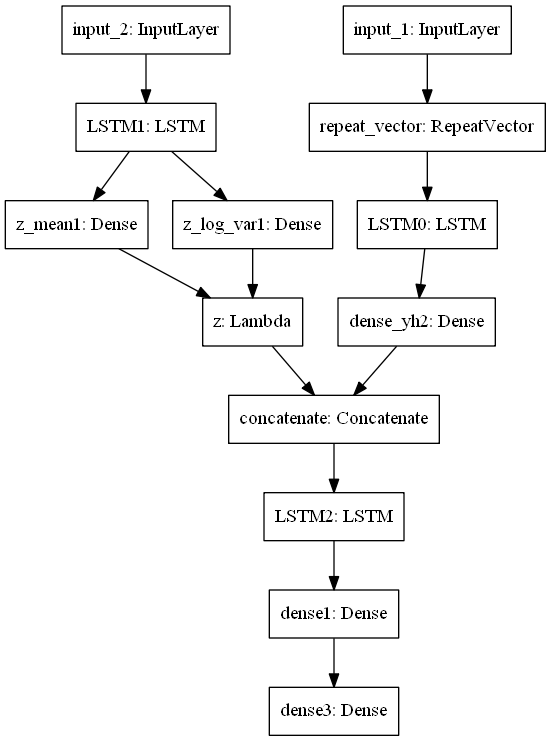

In [5]:
# 定义编码器的输入
y = Input(shape=(num_classes,))  # 输入类别
yh = RepeatVector(encoder_length)(y)
yh = LSTM(8, return_sequences=True, name='LSTM0')(yh)
yh = Dense(num_encoder_tokens, activation='relu',
           name='dense_yh2')(yh)  # 这里就是直接构建每个类别的均值

encoder_inputs = Input(shape=(encoder_length, num_encoder_tokens))

# 编码器，要求其返回状态
encoder = LSTM(latent_dim, return_sequences=True,
               return_state=False, name='LSTM1')

# 调用编码器，得到编码器的输出，以及状态信息 state_h 和 state_c
encoder_outpus = encoder(encoder_inputs)

z_mean = Dense(2, name='z_mean1')(encoder_outpus)
# z_mean = Dense(num_encoder_tokens, name='z_mean2')(z_mean1)
z_log_var = Dense(2, name='z_log_var1')(encoder_outpus)
# z_log_var = Dense(num_encoder_tokens, name='z_log_var2')(z_log_var1)

# 采样
# z_mean = RepeatVector(encoder_length)(z_mean)
# z_log_var = RepeatVector(encoder_length)(z_log_var)

z = Lambda(sampling, name='z')([z_mean, z_log_var])
# print(z_mean.shape,z_log_var.shape)
# 控制标签
zy = concatenate((z, yh), axis=-1)
# print(z.shape, yh.shape, zy.shape)

# 定义解码器的输入
# None表示可以处理任意长度的序列

# 接下来建立解码器，解码器将返回整个输出序列并且返回其中间状态
decoder_lstm = LSTM(latent_dim, return_sequences=True, name='LSTM2')

# 将编码器输出的状态作为初始解码器的初始状态
decoder_outputs = decoder_lstm(zy)

# 添加全连接层
decoder_dense1 = Dense(8, activation='relu', name='dense1')
# decoder_dense2 = Dense(5, activation='relu', name='dense2')
decoder_dense3 = Dense(num_encoder_tokens, activation='relu', name='dense3')
decoder_outputs = decoder_dense3(decoder_dense1(decoder_outputs))

# 定义整个模型
model = Model([encoder_inputs, y], decoder_outputs)

# 编译模型
# xent_loss是重构loss，kl_loss是KL loss,修改K.square(z_mean)为K.square(z_mean - yh)，也就是让隐变量向类内均值看齐


def VAE_loss(y_true, y_predicted):
    reconstruction_loss = K.sum(mse(y_true, y_predicted), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean - yh) - K.exp(z_log_var), axis=-1)
    return 1.2*K.mean(reconstruction_loss) + 0.8*K.mean(kl_loss)


model.compile(loss=VAE_loss, optimizer='Adam')

# print(model.summary())
plot_model(model)

# 模型训练与结果分析

In [6]:
History = model.fit([InLtrain,OutLtrain],Outtrain,epochs=epochs,batch_size=batch_size)

Train on 5531 samples
Epoch 1/20
5531/5531 [==============================] - 3s 471us/sample - loss: 0.6245
Epoch 2/20
5531/5531 [==============================] - 3s 476us/sample - loss: 0.4045
Epoch 3/20
5531/5531 [==============================] - 3s 472us/sample - loss: 0.3807
Epoch 4/20
5531/5531 [==============================] - 3s 469us/sample - loss: 0.3553
Epoch 5/20
5531/5531 [==============================] - 3s 487us/sample - loss: 0.3402
Epoch 6/20
5531/5531 [==============================] - 3s 477us/sample - loss: 0.3289
Epoch 7/20
5531/5531 [==============================] - 3s 486us/sample - loss: 0.3168
Epoch 8/20
5531/5531 [==============================] - 3s 487us/sample - loss: 0.3121
Epoch 9/20
5531/5531 [==============================] - 3s 502us/sample - loss: 0.3009
Epoch 10/20
5531/5531 [==============================] - 3s 489us/sample - loss: 0.2976
Epoch 11/20
5531/5531 [==============================] - 3s 499us/sample - loss: 0.2922s
Epoch 12/20
5531/5

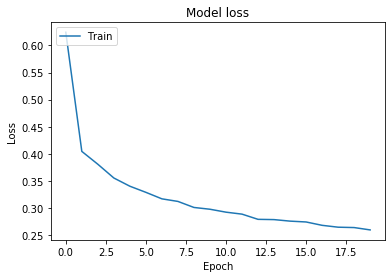

In [7]:
# 绘制训练 & 验证的损失值
plt.plot(History.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [8]:
score = model.evaluate([InLtest,OutLtest],Outtest)
print('Loss:', score)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Loss: 0.2734951370130301


# 可视化

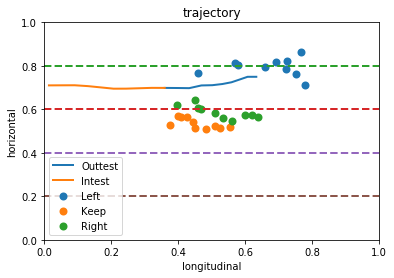

In [26]:
i = 18

vis1 = model.predict([[InLtest[i]], np.array([[1, 0, 0]])])
vis2 = model.predict([[InLtest[i]], np.array([[0, 1, 0]])])
vis3 = model.predict([[InLtest[i]], np.array([[0, 0, 1]])])

avis1 = vis1[0].swapaxes(0, 1)
avis2 = vis2[0].swapaxes(0, 1)
avis3 = vis3[0].swapaxes(0, 1)
aIntest = Intest101[i].swapaxes(0, 1)
aOuttest = Outtest101[i].swapaxes(0, 1)

plt.plot(aOuttest[1], aOuttest[0], lw=2, label="Outtest")
plt.scatter(avis1[1], avis1[0], lw=2, label="Left")
plt.scatter(avis2[1], avis2[0], lw=2, label="Keep")
plt.scatter(avis3[1], avis3[0], lw=2, label="Right")
plt.plot(aIntest[1], aIntest[0], lw=2, label="Intest")

plt.plot(np.linspace(0, 1, 2), [0.8, 0.8], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.6, 0.6], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.4, 0.4], lw=2, linestyle='--')
plt.plot(np.linspace(0, 1, 2), [0.2, 0.2], lw=2, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('trajectory')
plt.ylabel('horizontal')
plt.xlabel('longitudinal')
plt.legend()
plt.show()